# Doc2Vec (Figures 3, 4 and Tables 3, 4)

adapted (partially) from https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

In [1]:
import json
import re
from collections import namedtuple

import gensim

train = False

Document = namedtuple('Document', 'words tags')

alldocs = []  # will hold all docs in original order
with open('../data/c_twitter.json') as f_in:
    for i, line in enumerate(f_in):
        if (i % 3 == 0):
            c_twt = json.loads(line)
            # c_twt: {'weeknum': str, 'c_text': str, 'tags': [str]}
            words = c_twt['text'].split()
            tags = [str(c_twt['id'])] + c_twt['tags']
            alldocs.append(Document(words, tags))
        
shuffle_docs = alldocs[:]

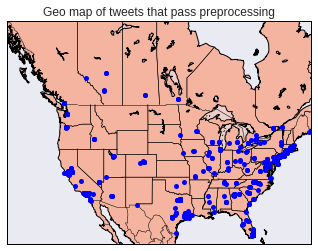

number of geo-tweets: 9370


In [2]:
import sys
if not('/high_spd_work/sm_w2v' in sys.path):
    sys.path.append('/high_spd_work/sm_w2v')
    
from sm_w2v.plot_utils import plot_map_twts
%matplotlib inline

def twt_gen():
    with open('../data/c_twitter.json') as f_in:
        for line in f_in:
            c_twt = json.loads(line)
            if 'coordinates' in c_twt:
                yield c_twt
            
geo_twts = list(twt_gen())
plot_map_twts(geo_twts, 'Geo map of tweets that pass preprocessing')
print('number of geo-tweets:', len(geo_twts))

# Build model and train (or load model from file)

In [3]:
import multiprocessing
from random import shuffle
import random
import time

from gensim.models import Doc2Vec
import gensim.models.doc2vec

import numpy as np

random.seed(1)
np.random.seed(1)



if train:
    cores = multiprocessing.cpu_count()
    assert gensim.models.doc2vec.FAST_VERSION > -1, "this will be painfully slow otherwise"

    # PV-DM w/average
    model= Doc2Vec(dm=1, dm_mean=1, size=100, window=3, negative=5, hs=0, min_count=2, workers=cores,
               max_vocab_size=10000, seed=1)


    # the array is too big
    model.build_vocab(alldocs)
    print("model:", model)

    # train model
    passes = 10
    start_time = time.time()

    for epoch in range(passes):
        shuffle(shuffle_docs)
        model.train(shuffle_docs)
        print(epoch, model.most_similar('hiv', topn=10))

        # do some validation after each epoch
        doc_ids = random.sample(range(len(alldocs)), 1000)
        score = 0
        for doc_id in doc_ids:
            inferred_docvec = model.infer_vector(alldocs[doc_id].words)
            score += sum(abs(model.docvecs[doc_id] - inferred_docvec))
        print("--- score: ", score)
        print("ELAPSED TIME (seconds): ", time.time() - start_time)

    model.save('../models/doc2vec.model')
else:
    model = Doc2Vec.load('../models/doc2vec.model')

model: Doc2Vec(dm/m,d100,n5,w3,mc2,t6)
0 [('hivaids', 0.8450294137001038), ('sexworkers', 0.763184666633606), ('humanrights', 0.7534171938896179), ('benegative', 0.7378150820732117), ('readyfora3', 0.7309142351150513), ('prep', 0.7219029068946838), ('pmtct', 0.7069050669670105), ('gettested', 0.6999102830886841), ('hivtestweek', 0.6992250680923462), ('sexwork', 0.6983253955841064)]
--- score:  14259.2156627
ELAPSED TIME (seconds):  265.9788086414337
1 [('hivaids', 0.8823283910751343), ('hivtestweek', 0.8124627470970154), ('kolastirio', 0.7993541955947876), ('humanrights', 0.791448175907135), ('staynegathive', 0.7898387908935547), ('wad2015ke', 0.7822160720825195), ('sexworkers', 0.773891270160675), ('wad2015ng', 0.7723400592803955), ('knowyourstatus', 0.7670961022377014), ('positiveteens', 0.765618085861206)]
--- score:  18304.1116717
ELAPSED TIME (seconds):  466.6624324321747
2 [('hivaids', 0.8978808522224426), ('hivtestweek', 0.8344994783401489), ('staynegathive', 0.8227516412734985)

# Table 4: Related Word-Vectors

In [4]:
import pandas as pd
new_vecs = model.most_similar(['hivaids'], topn=10)
df_hivaids = pd.DataFrame(data=new_vecs, columns=['Related-Word', 'Cosine Similarity to \"hivaids\"'])
df_hivaids

,Related-Word,"Cosine Similarity to ""hivaids"""
0,hiv,0.907034
1,hiv-aids,0.830694
2,aidshiv,0.819709
3,communityhealthworkers,0.765807
4,hivtestweek,0.762888
5,givingtuesday,0.724212
6,imtesting,0.718646
7,hivheartchat,0.716131
8,hiv-,0.716027
9,raghwanij,0.715862


In [5]:
new_vecs = model.most_similar(['prep'], topn=10)
df_prep = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"prep\"'])
df_prep

,Related Word,"Cosine Similarity to ""prep"""
0,truvada,0.846581
1,benegative,0.805897
2,charliesheen,0.794697
3,hivtestweek,0.784692
4,hiv,0.752715
5,icasa2015,0.750663
6,gettested,0.748227
7,worldaidsday,0.733604
8,doingit,0.731456
9,sexwork,0.729755


In [6]:
new_vecs = model.most_similar(['prophylaxis'], topn=10)
df_prophylaxis = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"prophylaxis\"'])
df_prophylaxis

,Related Word,"Cosine Similarity to ""prophylaxis"""
0,adherence,0.532281
1,hcv,0.451839
2,prep,0.450373
3,sexworkers,0.435853
4,markers,0.427471
5,medicine,0.419857
6,activity,0.415121
7,zambia,0.410007
8,invest,0.409541
9,hiv-associated,0.404038


In [7]:
new_vecs = model.most_similar(['truvada'], topn=10)
df_truvada = pd.DataFrame(data=new_vecs, columns=['Related Word', 'Cosine Similarity to \"truvada\"'])
df_truvada

,Related Word,"Cosine Similarity to ""truvada"""
0,prep,0.846581
1,charliesheen,0.760951
2,worldaidsday,0.751197
3,hivtestweek,0.746494
4,hiv,0.719975
5,icasa2015,0.702110
6,aids,0.700500
7,benegative,0.691244
8,aidsfreefuture,0.681298
9,martinshkreli,0.678818


# Figure 3: PCA and tSNE plots of relevent word vectors

PCA explained variance ratio:  [ 0.07754078  0.06180783]


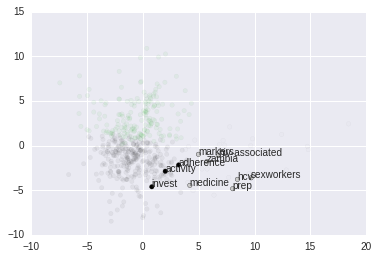

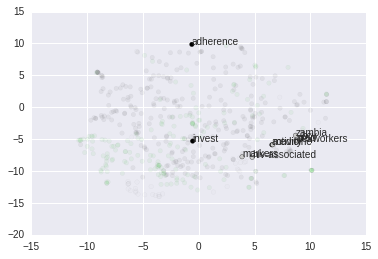

In [26]:
import sys

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# append path to my module
if '/high_spd_work/sm_w2v' not in sys.path:
    sys.path.append('/high_spd_work/sm_w2v')
from sm_w2v.plot_utils import scatter_plot

# related words from above
related_words = list(df_prophylaxis.iloc[:,0].values)

# Prepare data matrix
X = []
text_annotations = []
for word in model.vocab:
    X.append(model[word])
    if word in related_words:
        text_annotations.append(word)
    else:
        text_annotations.append("")
X = np.array(X)

# Do k-means on original data matrix
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans_labels = kmeans.fit_predict(X)

# Do PCA
pca = PCA(n_components=2, copy=True)
pca.fit(X)
print("PCA explained variance ratio: ", pca.explained_variance_ratio_)
pca_comps = pca.transform(X)

# Do tSNE
tsne = TSNE(n_components=2, random_state=1)
tsne_comps = tsne.fit_transform(X)

# Scatter plot
rand_seed = 0
alpha_high = 1.0
alpha_low = 0.05
down_samp_rate = 0.1

# save PCA plot in 'notebooks' directory
scatter_plot(pca_comps[:,0], pca_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig3a: PCA of Related Words", rand_seed, None)

# save tSNE plot in 'notebooks' directory
scatter_plot(tsne_comps[:,0], tsne_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig3b: tSNE of Related Words", rand_seed, None)

# Table 4: Related Hashtags and Tweets

Hashtags begin with "#", users begin with "user--" and tweets are just a number - that refers to the corresponding index in the "alldocs" variable, or the "../data/c_twitter.json" cleaned tweets file

In [27]:
new_vecs = model.docvecs.most_similar(['#truvada'], topn=10)
df_hash_truvada = pd.DataFrame(data=new_vecs, columns=['Related Hashtag/User/Tweet', 'Cosine Similarity to \"#truvada\"'])
df_hash_truvada

,Related Hashtag/User/Tweet,"Cosine Similarity to ""#truvada"""
0,#prep,0.710134
1,#hiv,0.649483
2,#prevention,0.620749
3,#hivtesting,0.615185
4,#prepworks,0.608087
5,#メル友,0.590625
6,#セフレ,0.590555
7,#bbbh,0.559889
8,#themorningfix,0.558508
9,685958220108660736,0.556735


In [28]:
# new_vecs = model.docvecs.most_similar(['#sexwork'], topn=10)
# df_hash_sexwork = pd.DataFrame(data=new_vecs, columns=['Related Hashtag/User/Tweet', 'Cosine Similarity to \"#sexwork\"'])
# df_hash_sexwork

In [29]:
new_vecs = model.docvecs.most_similar(['#prep'], topn=10)
df_hash_prep = pd.DataFrame(data=new_vecs, columns=['Related Related Hashtag/User/Tweet', 'Cosine Similarity to \"#prep\"'])
df_hash_prep

,Related Related Hashtag/User/Tweet,"Cosine Similarity to ""#prep"""
0,#hiv,0.722262
1,#truvada,0.710134
2,#prepworks,0.654581
3,#prevention,0.649329
4,#メル友,0.647412
5,#セフレ,0.647203
6,#gay,0.615370
7,687395919013261312,0.605419
8,685805487284207616,0.598782
9,689027472776630274,0.596652


In [30]:
# note, this tweet is popular, warning about 13 signs which indicate that you need HIV testing.
# We see evidence of this populat tweet-retweet in both DTM and Doc2Vec:
#
# Document(words=['#', 'krtebireysyle', 'if', 'you', 'see', 'this', '13',
# 'symptoms', '.', 'do', 'hiv', 'test', 'immediately', '.', 'please', 'read'],
# tags=[603177, '#KFB_Mz_Sope', 'kürtçebirşeysöyle'])
#
[doc for doc in alldocs if int(doc.tags[0]) == 689027472776630274]

[Document(words=['#', 'bluemonday', 'if', 'you', 'see', 'this', '13', 'symptoms', '.', 'do', 'hiv', 'test', 'immediately', '.', 'please', 'read'], tags=['689027472776630274', '♔KINDLY FOLLOW BACK♔-*-4171549167', '#bluemonday'])]

In [31]:
new_vecs = model.docvecs.most_similar(['#imtesting'], topn=10)
df_hash_imtesting = pd.DataFrame(data=new_vecs, columns=['Related Related Hashtag/User/Tweet', 'Cosine Similarity to \"#imtesting\"'])
df_hash_imtesting

,Related Related Hashtag/User/Tweet,"Cosine Similarity to ""#imtesting"""
0,#hivtestweek,0.653922
1,#wadirl,0.572963
2,#gettested,0.571273
3,#eurohivheptestweek,0.521028
4,#wad2015,0.482180
5,CDC STD-*-118828764,0.477269
6,#doingit,0.471714
7,yorkshire mesmac-*-74150233,0.461470
8,#worldaidsday,0.453619
9,David Rowlands-*-2416339741,0.446851


# Figure 4: Related Hashtags and Tweets

PCA explained variance ratio:  [ 0.06554642  0.04239962]


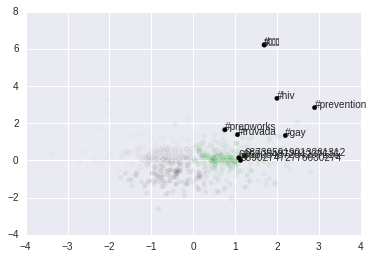

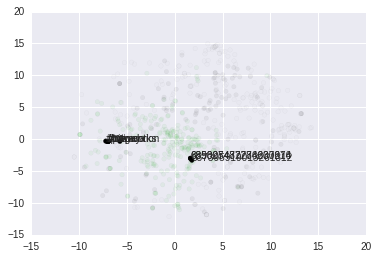

In [32]:
# related words from above
related_words = list(df_hash_prep.iloc[:,0].values)


# Prepare data matrix
X = []
text_annotations = []
for i, word in enumerate(model.docvecs.doctags):
    if (i % 100 == 0 or word in related_words) :
        X.append(model.docvecs[word])
        if word in related_words:
            text_annotations.append(word)
        else:
            text_annotations.append("")
X = np.array(X)

# Do k-means on original data matrix
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans_labels = kmeans.fit_predict(X)

# Do PCA
pca = PCA(n_components=2, copy=True)
pca.fit(X)
print("PCA explained variance ratio: ", pca.explained_variance_ratio_)
pca_comps = pca.transform(X)

# Do tSNE
tsne = TSNE(n_components=2, random_state=1)
tsne_comps = tsne.fit_transform(X)

# Scatter plot
rand_seed = 0
alpha_high = 1.0
alpha_low = 0.05
down_samp_rate = 0.1

# save PCA plot in 'notebooks' directory (it won't show here in the notebook)
scatter_plot(pca_comps[:,0], pca_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig4a: PCA of Related Hashtags-Users-Tweets", rand_seed, None)

# save tSNE plot in 'notebooks' directory (it won't show here in the notebook)
scatter_plot(tsne_comps[:,0], tsne_comps[:,1], alpha_high, alpha_low,
            kmeans_labels, text_annotations,
            down_samp_rate, "Fig4b: tSNE of Hashtags-Users-Tweets", rand_seed, None)

# get ~24,000 users related to PrEP sorted

and store in '../data/top_users_to_PrEP.txt'


this is providing data for other notebook:

`topic_modeling_on_user-timelines.ipynb`

and was only run once:



In [33]:
# # get top 1000 user id strings and save for user-timeline analysis
# sim_vecs = model.docvecs.most_similar(['#prep'], topn=100000)
# users = []
# for v in sim_vecs:
#     l = v[0].split('-*-')
#     if len(l) > 1:
#         users.append(l[-1])

# with open('../data/top_users_to_PrEP.txt', 'w') as f_out:
#     f_out.write('\n'.join(users))
